In [26]:
import random                        # Library to generate random numbers
import skimage                       # Library for image manipulation
import numpy as np                   # Library for array manipulation
import urllib.request                # Library to download data
import matplotlib.pyplot as plt      # Library used for plotting
from skimage import io, measure               # Module from skimage
from skimage.io import imread        # Module from skimage to read images as numpy arrays
from skimage.filters import gaussian # Module working with a gaussian filter
import pathlib                              # Library to work with file paths
import os
from ipywidgets import interactive, HBox, VBox, Layout
import ipywidgets as widgets
from skimage.morphology import binary_dilation
from skimage.segmentation import watershed
from skimage.draw import polygon
from skimage.measure import regionprops
from skimage.color import label2rgb
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from skimage.morphology import binary_closing
from skimage.morphology import binary_opening
from skimage.morphology import disk
from skimage.morphology import remove_small_objects
from scipy import ndimage as ndi              # Distance Transform
from skimage.feature import peak_local_max    # Local maxima in a matrix
from skimage.segmentation import watershed    # Watershed algorithm
from skimage.filters import difference_of_gaussians
from cellpose import plot, models
import pandas as pd

In [27]:
# Load the image
figName = 'C:/Users/apurv/OneDrive/Desktop/QBio/Challenges/UQbio2024_Team5/Drug5_1000nM/rep1_FOV3.tif'
images = imread(figName)
img = images[0,:,:,0]

In [28]:
# RUN CELLPOSE
model = models.Cellpose(model_type='cyto') # model_type='cyto' or model_type='nuclei'
masks  = model.eval(img, diameter=100)[0]
num_cells= len(np.unique(masks))-1

In [29]:
print(num_cells)

11


In [30]:
# Segment nuclei and cytosol
zSlice = 16
images_FISH = images
img_nuc = images_FISH[zSlice,:,:,0:2]
use_GPU = False  # Set to True if you have a GPU - this will make it MUCH faster.
model_nuc = models.Cellpose(gpu=use_GPU, model_type='nuclei') # model_type='cyto' or model_type='nuclei'
masks_nuc = model_nuc.eval(img_nuc, diameter=100, channels=[0,1])[0]

In [31]:
img_cyto = images_FISH[zSlice,:,:,0:3]
model_cyto = models.Cellpose(gpu=use_GPU, model_type='cyto2') # model_type='cyto', 'cyto2' or model_type='nuclei'
masks_cyto, flows, styles, diams = model_cyto.eval(img_cyto, diameter=200, channels=[0,2])


In [32]:
nucleus_indices = np.zeros(np.max(masks_cyto)+1)
for i in range(1,np.max(masks_nuc)+1):
    posn_nucl = np.mean(np.where(masks_nuc==i),axis=1).astype(int)
    nucleus_indices[masks_cyto[posn_nucl[0],posn_nucl[1]]] = i

In [33]:
# Counting the detected particles in each cell
list_cytosol_particles = np.zeros(num_cells)
list_nuclear_particles = np.zeros(num_cells)


C:\Users\apurv\AppData\Local\Temp\ipykernel_5060\2494462635.py:23: RuntimeWarning: divide by zero encountered in log10
  ax[1,1].plot(survival, np.log10(np.arange(len(survival))))


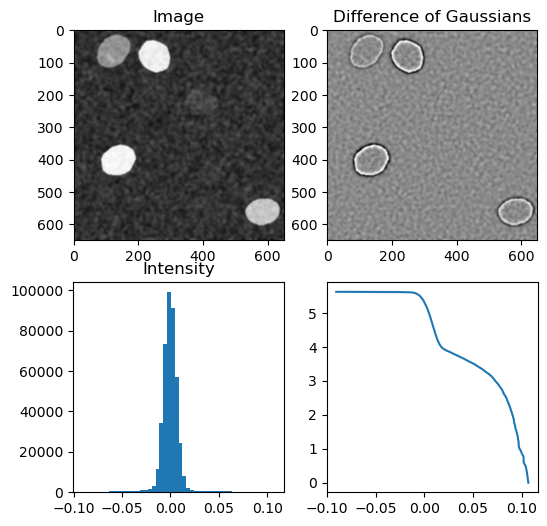

intensity range:  -0.09072214040046456 0.1078519702717084


In [34]:
# Selecting the color channel with RNA spots
zSlice = 16 #time frame
iChannel = 1 #which channel 
img_spots = images_FISH[zSlice,:,:,iChannel]

# Show the original image
fig, ax = plt.subplots(2,2, figsize=(6, 6))
ax[0,0].imshow(img_spots,cmap='Greys_r')
ax[0,0].set(title='Image')

# Apply a difference of Gaussians filter to the image to enhance spots
img_spots_filtered = difference_of_gaussians(img_spots,low_sigma=1, high_sigma=5)
ax[0,1].imshow(img_spots_filtered,cmap='Greys_r')
ax[0,1].set(title= 'Difference of Gaussians' )

# Make a histogram of the intensity values
ax[1,0].hist(img_spots_filtered.flatten(),bins=50)
ax[1,0].set(title= 'Intensity' )

# Make a survival plot of the intensity values
survival = np.sort(img_spots_filtered.flatten())
survival = survival[::-1]
ax[1,1].plot(survival, np.log10(np.arange(len(survival))))

plt.show()
print('intensity range: ', np.min(img_spots_filtered), np.max(img_spots_filtered))

In [35]:
import trackpy as tp # Library for particle tracking
# This section generates an histogram with the intensity of the detected particles in the image.
particle_size = 5 # according to the documentation must be an odd number 3,5,7,9 etc.
minimal_intensity_for_selection = 0 # minimal intensity to detect a particle.
# "spots_detected_dataframe" is a pandas data frame that contains the information about the detected spots
spots_detected_dataframe = tp.locate(img_spots, diameter=particle_size, minmass=minimal_intensity_for_selection)
print(spots_detected_dataframe)

               y           x      mass      size           ecc    signal  \
0       2.310881  228.411917  6.810787  1.378029  8.926174e-01  1.552718   
1       3.435159   43.170029  6.122651  1.314955  3.072697e-01  1.499785   
2       3.320197  183.330049  3.581839  1.393157  1.164441e+00  1.270406   
3       3.000000  284.000000  1.288050  0.000000  7.300000e+07  1.288050   
4       4.350299  304.206587  5.893272  1.466186  2.095808e-01  1.288050   
...          ...         ...       ...       ...           ...       ...   
2891  646.605970  133.471642  5.910916  1.276656  6.054608e-01  1.323339   
2892  646.683333  246.379167  4.234686  0.834166  5.269461e-01  1.605652   
2893  646.323671  268.381643  3.652417  1.414214  2.946860e-01  1.288050   
2894  646.617722  317.792405  6.969588  1.017567  5.968997e-01  1.552718   
2895  646.764493  485.485507  4.869889  1.295197  1.120736e+00  1.393918   

      raw_mass        ep  
0        555.0  2.165244  
1        487.0 -1.104322  
2     

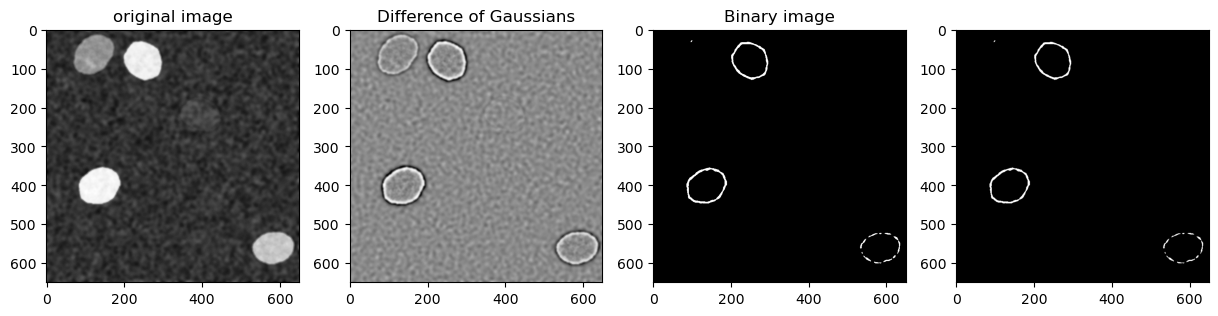

In [36]:
threshold = 0.05
# Show original image in MS2 channel
fig, ax = plt.subplots(1,4, figsize=(15, 6))
ax[0].imshow(img_spots,cmap='Greys_r')
ax[0].set(title='original image')

# Apply a difference of Gaussians filter to the image to enhance spots
ax[1].imshow(img_spots_filtered,cmap='Greys_r')
ax[1].set(title= 'Difference of Gaussians' )

# Apply a Threshold to the image to create binary image
img_spots_binary = img_spots_filtered.copy()
img_spots_binary[img_spots_binary>=threshold] = threshold # Making spots above the threshold equal to the threshold value.
img_spots_binary[img_spots_binary<threshold] = 0 # Making spots below the threshold equal to 0.
ax[2].imshow(img_spots_binary,cmap='Greys_r')
ax[2].set(title= 'Binary image' )

# Image binarization
img_spots_binary[img_spots_binary!=0] = 1 # Binarization
ax[3].imshow(img_spots_binary, cmap=plt.cm.gray)


In [20]:
# Labeling. Joining pixels in "particles"
spot_contours = measure.find_contours(img_spots_binary, 0.5)
for contour in spot_contours:
    ax[3].plot(contour[:, 1], contour[:, 0], linewidth=2)
ax[3].set(title= str(len(spot_contours))+' Detected particles' )
plt.show()

In [37]:
# Loop through the cytosol masks
for i in range(len(spot_contours)):
    # Find the position of the particle
    posn = np.mean(spot_contours[i], axis=0).astype(int)

    # Check which cyto mask is the particle in
    cell_num = masks_cyto[posn[0], posn[1]]
    if cell_num > 0:
        list_cytosol_particles[cell_num] += 1

        # Check if the particle is also in the nucleus
        if masks_nuc[posn[0], posn[1]] == nucleus_indices[cell_num]:
            list_nuclear_particles[cell_num] += 1


In [38]:
# Prepare the answer dictionary
answerDict = {
    'CellCount': [],
    'CellArea': [],
    'mRNA_nucleus': [],
    'mRNA_cytosol': []
}

In [39]:
# Fill the answer dictionary
for cell_id in range(1, num_cells+1):
    cell_area = np.sum(masks_cyto==cell_id)
    mRNA_nucleus = list_nuclear_particles[cell_id-1]
    mRNA_cytosol = list_cytosol_particles[cell_id-1] - mRNA_nucleus
    
    answerDict['CellCount'].append(cell_id)
    answerDict['CellArea'].append(cell_area)
    answerDict['mRNA_nucleus'].append(mRNA_nucleus)
    answerDict['mRNA_cytosol'].append(mRNA_cytosol)

In [40]:

# Display the result
print(answerDict)

{'CellCount': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'CellArea': [17179, 10230, 21596, 10873, 0, 0, 0, 0, 0, 0, 0], 'mRNA_nucleus': [0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'mRNA_cytosol': [0.0, 2.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


In [41]:
import pandas as pd
# Converting dictionary to DataFrame
df = pd.DataFrame(answerDict)

# Displaying the DataFrame
print(df)

    CellCount  CellArea  mRNA_nucleus  mRNA_cytosol
0           1     17179           0.0           0.0
1           2     10230           0.0           2.0
2           3     21596           2.0           0.0
3           4     10873           2.0           0.0
4           5         0           0.0           8.0
5           6         0           0.0           0.0
6           7         0           0.0           0.0
7           8         0           0.0           0.0
8           9         0           0.0           0.0
9          10         0           0.0           0.0
10         11         0           0.0           0.0
